## Simulating synthetic data

In [2]:
using CSV, DataFrames,  Dates, Distributions, Query
using CairoMakie, Random

In [3]:
include("../src/BayesTS/BayesTS.jl")
using .BayesTS

In [4]:
# Load helper functions 
include("../src/BayesTShelpersMulti.jl")
include("../src/DataHelpers.jl")
include("../src/ForwardSimulation.jl")
include("../src/InferenceHelpers.jl")
include("../src/lifetimes.jl")
include("../src/PosteriorHelpers.jl")
include("../src/PlotFunctions.jl")

plot_EC_smooth (generic function with 1 method)

In [12]:
# Model setup
Random.seed!(10)
T = 400 # Number of days
seed_L = 14 # Seeded days
g = generation_time(20, 5.0, 0.3)
onset = onset_time(20, 4.5, 0.6, 0.8)
g_rev = reverse(g)
onset_rev = reverse(onset)
model = SplineTrend(20, T, 4)
prior_model = [["LAS"]]

1-element Vector{Vector{String}}:
 ["LAS"]

In [1043]:
## Make R
t = collect(1:T)
X = get_design(model, t)

# Using Radial Basis Function on β for parameters
μ1 = 6
σ1 = 4
μ2 = 14
σ2 = 6
x = collect(1:size(X,2))
β1 = @. 0.4 * exp(-((x-μ1)/σ1)^2) - 0.1
β2 =  @. 0.1 * exp(-((x-μ2)/σ2)^2) + 0.1
R = exp.(X * [β1 β2])

# Inital Infections
I0 = [100., 1.]

# Generating random number of sequences each day
EN = @. 50 * exp(0.01 * t * sin(0.05 * t)) / (1 + exp(0.01 * t * sin(0.05 * t)))
N = rand.(Poisson.(EN))

# Over-dispersion and reporting rates
α = 0.1
ρ = [0.6, 0.3, 0.3, 0.7, 0.5, 0.5, 0.6]
ρ_vec = get_reporting_vector(ρ, T)

400-element Vector{Float64}:
 0.6
 0.3
 0.3
 0.7
 0.5
 0.5
 0.6
 0.6
 0.3
 0.3
 0.7
 0.5
 0.5
 ⋮
 0.7
 0.5
 0.5
 0.6
 0.6
 0.3
 0.3
 0.7
 0.5
 0.5
 0.6
 0.6

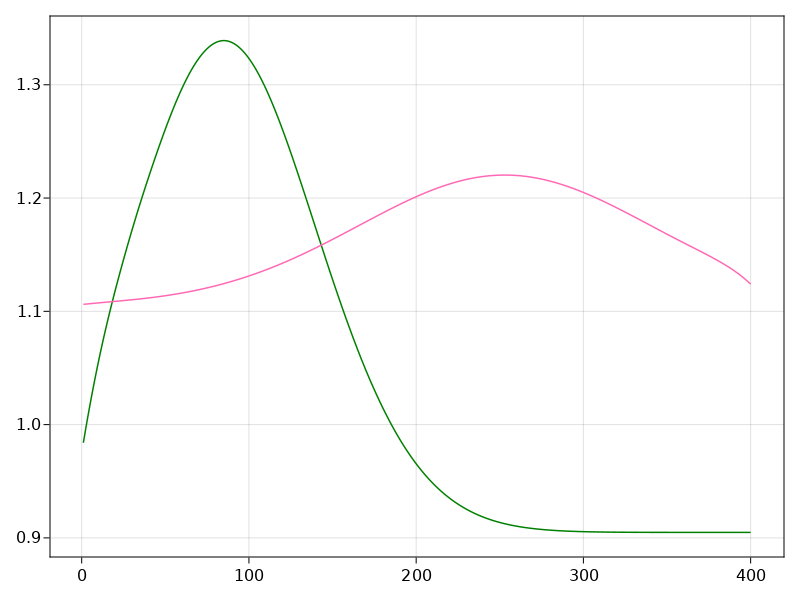

In [1045]:
fig = Figure()
ax = fig[1,1] = Axis(fig)
lines!(ax, R[:,1], color = :green)
lines!(ax, R[:,2], color = :hotpink)
fig

In [1046]:
# Simulate Epidemic
obs_counts, obs_cases, true_I, true_freq = forward_simulate_lineages(R, I0, g_rev, onset_rev, α, ρ_vec, N, seed_L)

forward_simulate_lineages (generic function with 1 method)

In [1048]:
lineage_names = ["A", "B"]
state_name = "synthetic"

function make_plot_dataframe(obs_cases, obs_counts, lineage_names, state_name)
    cases = Int[]
    counts = Int[]
    obs_freqs = Float64[]
    dates = Int[]
    lineages = String[]
    lineages_num = Int[]
    state = String[]
    
    T = length(obs_cases)
    N_lineage = size(obs_counts,2)
    
    obs_freq = obs_counts ./ sum(obs_counts, dims=2)
    
    
    for lineage in 1:N_lineage
        dates = vcat(dates, collect(1:T))
        cases = vcat(cases, obs_cases)
        counts = vcat(counts, obs_counts[:, lineage])
        obs_freqs = vcat(obs_freqs, obs_freq[:, lineage])
        lineages_num = vcat(lineages_num, repeat([lineage], T))
        lineages  = vcat(lineages, repeat([lineage_names[lineage]], T))
        state = vcat(state, repeat([state_name], T))
    end
    
    return DataFrame(date = dates, cases = cases, counts = Int.(counts), obs_freqs = obs_freqs, lineage = lineages, lineage_num = lineages_num, state = state)   
end

synthetic_df = make_plot_dataframe(obs_cases, obs_counts, lineage_names, state_name)
first(synthetic_df, 10)

,date,cases,counts,obs_freqs,lineage,lineage_num,state
,Int64,Int64,Int64,Float64,String,Int64,String
1,1,47,19,1.0,A,1,synthetic
2,2,38,23,1.0,A,1,synthetic
3,3,40,23,1.0,A,1,synthetic
4,4,55,17,1.0,A,1,synthetic
5,5,101,19,1.0,A,1,synthetic
6,6,128,20,0.952381,A,1,synthetic
7,7,84,23,0.958333,A,1,synthetic
8,8,67,29,0.966667,A,1,synthetic
9,9,39,22,1.0,A,1,synthetic


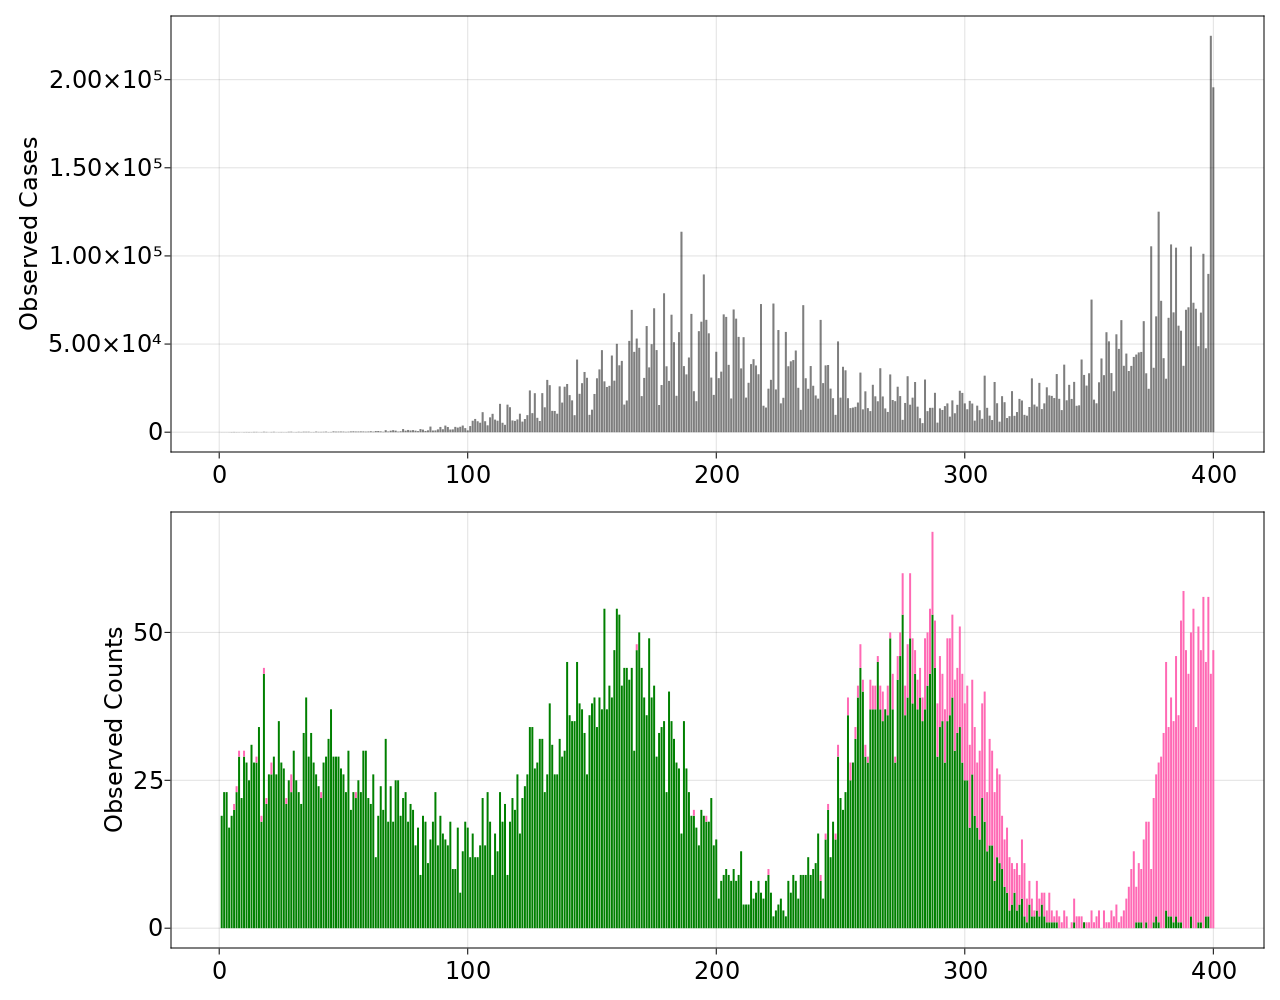

In [1049]:
synthetic_colors = [ "green", "hotpink"]
syn_color_vec = [synthetic_colors[i] for i in synthetic_df.lineage_num]

fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 1000), fontsize = 24)
ax1 = fig[1, 1] = Axis(fig,ylabel = "Observed Cases")
barplot!(ax1, synthetic_df.date, synthetic_df.cases, 
    color = ("black", 0.3))

ax2 = fig[2, 1] = Axis(fig,ylabel = "Observed Counts")
barplot!(ax2, synthetic_df.date, synthetic_df.counts, 
    stack = synthetic_df.lineage_num,
    color = syn_color_vec)

fig

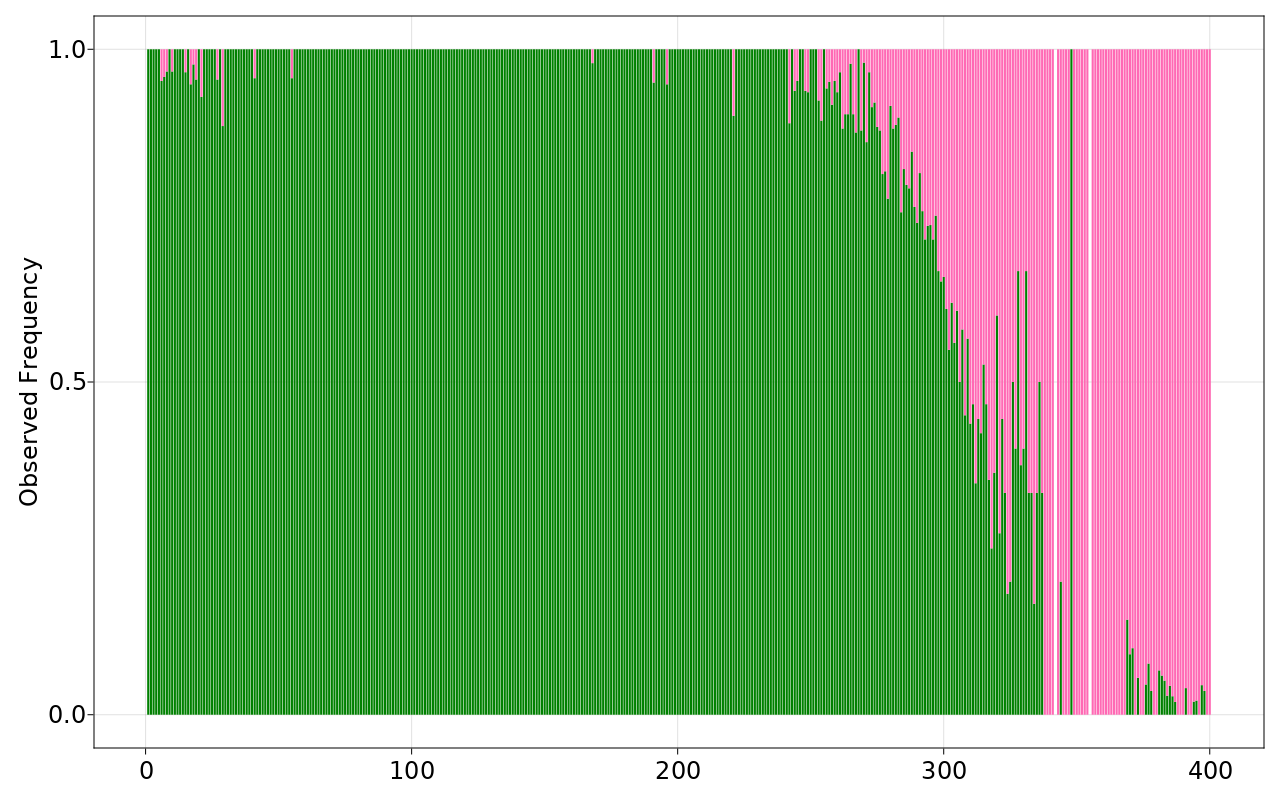

In [1050]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Observed Frequency")

barplot!(ax, synthetic_df.date, synthetic_df.obs_freqs, 
    stack = synthetic_df.lineage_num,
    color = syn_color_vec)

fig

In [1058]:
# Export Case Counts and Observed Lineage Annotations
synthetic_df = export_dataframe_for_modeling(obs_cases, obs_counts, lineage_names, state_name)
CSV.write("../data/processed/synthetic_data.csv", synthetic_df)
first(synthetic_df, 10)

,state,cases,date,sequences_total,sequences_A,sequences_B
,String,Int64,Date,Int64,Int64,Int64
1,synthetic,47,2020-01-01,19,19,0
2,synthetic,38,2020-01-02,23,23,0
3,synthetic,40,2020-01-03,23,23,0
4,synthetic,55,2020-01-04,17,17,0
5,synthetic,101,2020-01-05,19,19,0
6,synthetic,128,2020-01-06,21,20,1
7,synthetic,84,2020-01-07,24,23,1
8,synthetic,67,2020-01-08,30,29,1
9,synthetic,39,2020-01-09,22,22,0


## Running model on this 

In [7]:
synthetic_df = DataFrame(CSV.File("../data/processed/synthetic_data.csv"))

,state,cases,date,sequences_total,sequences_A,sequences_B
,String,Int64,Date,Int64,Int64,Int64
1,synthetic,47,2020-01-01,19,19,0
2,synthetic,38,2020-01-02,23,23,0
3,synthetic,40,2020-01-03,23,23,0
4,synthetic,55,2020-01-04,17,17,0
5,synthetic,101,2020-01-05,19,19,0
6,synthetic,128,2020-01-06,21,20,1
7,synthetic,84,2020-01-07,24,23,1
8,synthetic,67,2020-01-08,30,29,1
9,synthetic,39,2020-01-09,22,22,0


In [13]:
# Running independent model as easy as possible
using CmdStan
ENV["JULIA_CMDSTAN_HOME"]="/Users/marlinfiggins/cmdstan/"
CmdStan.set_cmdstan_home!(ENV["JULIA_CMDSTAN_HOME"])

syn_dict = process_all_states("../src/stan_models/Rt_Structured_lineage_ind.stan", synthetic_df, 
    g, onset, 
    seed_L, 0, 
    model; priors = prior_model, 
    model_name = "synthetic")

Dict{Any, Any} with 1 entry:
  "synthetic" => Dict{String, Any}("seq_labels"=>SubString{String}["A" "B"], "s…

In [1112]:
run_stan_model!("synthetic", syn_dict)

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[3] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/synthetic/synthetic/rt-lineages-synthetic.stan', line 216, column 2 to column 81)Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/synthetic/synthetic/rt-lineages-synthetic.stan', line 216, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,but if this warni

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[194] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/synthetic/synthetic/rt-lineages-synthetic.stan', line 216, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location paramet

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[19] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/synthetic/synthetic/rt-lineages-synthetic.stan', line 216, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: double_exponential_lpdf: Scale parameter is 0, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/synthetic/synthetic/rt-lineages-synthetic.stan', line 209, column 2 to column 41)
If this warning occurs sporadically, such as for

Inference for Stan model: rt_lineages_synthetic_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (156, 149, 161, 157) seconds, 10 minutes total
Sampling took (101, 80, 94, 94) seconds, 6.2 minutes total

                          Mean     MCSE   StdDev        5%       50%       95%    N_Eff  N_Eff/s    R_hat

lp__                  -5.3e+03  3.8e-01  9.0e+00  -5.4e+03  -5.3e+03  -5.3e+03  5.6e+02  1.5e+00  1.0e+00
accept_stat__             0.89  1.9e-03  1.1e-01      0.67      0.92      1.00  3.2e+03  8.6e+00  1.0e+00
stepsize__               0.027  5.8e-05  2.6e-03     0.024     0.026     0.031  2.0e+03  5.4e+00  2.4e+13
treedepth__                7.2  8.5e-02  4.7e-01       7.0       7.0       8.0  3.0e+01  8.2e-02  1.0e+00
n_leapfrog__               182  1.0e+01  6.9e+01       127       127       255  4.3e+01  1.2e-01  1.0e+00
divergent__               0.00      nan  0.0e+00      0.00      0.00      0.00      

R[276,2]               1.2e+00  3.4e-04  2.3e-02   1.2e+00   1.2e+00   1.2e+00  4.5e+03  1.2e+01  1.0e+00
R[277,1]               9.0e-01  1.8e-04  1.2e-02   8.8e-01   9.0e-01   9.2e-01  4.6e+03  1.2e+01  1.0e+00
R[277,2]               1.2e+00  3.3e-04  2.2e-02   1.2e+00   1.2e+00   1.2e+00  4.6e+03  1.2e+01  1.0e+00
R[278,1]               9.0e-01  1.8e-04  1.2e-02   8.8e-01   9.0e-01   9.2e-01  4.6e+03  1.2e+01  1.0e+00
R[278,2]               1.2e+00  3.2e-04  2.2e-02   1.2e+00   1.2e+00   1.2e+00  4.6e+03  1.3e+01  1.0e+00
R[279,1]               9.0e-01  1.7e-04  1.2e-02   8.8e-01   9.0e-01   9.2e-01  4.6e+03  1.3e+01  1.0e+00
R[279,2]               1.2e+00  3.1e-04  2.1e-02   1.2e+00   1.2e+00   1.2e+00  4.7e+03  1.3e+01  1.0e+00
R[280,1]               9.0e-01  1.7e-04  1.2e-02   8.8e-01   9.0e-01   9.2e-01  4.7e+03  1.3e+01  1.0e+00
R[280,2]               1.2e+00  3.1e-04  2.1e-02   1.2e+00   1.2e+00   1.2e+00  4.7e+03  1.3e+01  1.0e+00
R[281,1]               9.0e-01  1.7e-04  1.2e-

rho_vec[370]           5.1e-01  1.3e-03  4.5e-02   4.3e-01   5.1e-01   5.8e-01  1.2e+03  3.3e+00  1.0e+00
rho_vec[371]           5.7e-01  1.4e-03  5.0e-02   4.9e-01   5.7e-01   6.5e-01  1.2e+03  3.3e+00  1.0e+00
rho_vec[372]           5.9e-01  1.5e-03  5.1e-02   5.1e-01   5.9e-01   6.7e-01  1.2e+03  3.3e+00  1.0e+00
rho_vec[373]           3.0e-01  7.6e-04  2.7e-02   2.5e-01   3.0e-01   3.4e-01  1.3e+03  3.4e+00  1.0e+00
rho_vec[374]           2.9e-01  7.5e-04  2.6e-02   2.5e-01   2.9e-01   3.3e-01  1.2e+03  3.2e+00  1.0e+00
rho_vec[375]           6.5e-01  1.6e-03  5.4e-02   5.6e-01   6.5e-01   7.4e-01  1.2e+03  3.3e+00  1.0e+00
rho_vec[376]           4.9e-01  1.3e-03  4.4e-02   4.2e-01   4.9e-01   5.6e-01  1.2e+03  3.3e+00  1.0e+00
rho_vec[377]           5.1e-01  1.3e-03  4.5e-02   4.3e-01   5.1e-01   5.8e-01  1.2e+03  3.3e+00  1.0e+00
rho_vec[378]           5.7e-01  1.4e-03  5.0e-02   4.9e-01   5.7e-01   6.5e-01  1.2e+03  3.3e+00  1.0e+00
rho_vec[379]           5.9e-01  1.5e-03  5.1e-

I[293,2]               1.3e+03  3.7e+00  1.4e+02   1.1e+03   1.3e+03   1.6e+03  1.5e+03  3.9e+00  1.0e+00
I[294,1]               5.9e+03  1.5e+01  5.6e+02   5.0e+03   5.8e+03   6.9e+03  1.3e+03  3.6e+00  1.0e+00
I[294,2]               1.4e+03  3.9e+00  1.5e+02   1.2e+03   1.4e+03   1.6e+03  1.4e+03  3.9e+00  1.0e+00
I[295,1]               5.8e+03  1.5e+01  5.5e+02   4.9e+03   5.7e+03   6.8e+03  1.3e+03  3.6e+00  1.0e+00
I[295,2]               1.4e+03  4.0e+00  1.5e+02   1.2e+03   1.4e+03   1.7e+03  1.4e+03  3.9e+00  1.0e+00
I[296,1]               5.6e+03  1.5e+01  5.4e+02   4.8e+03   5.6e+03   6.6e+03  1.3e+03  3.6e+00  1.0e+00
I[296,2]               1.5e+03  4.1e+00  1.6e+02   1.2e+03   1.5e+03   1.8e+03  1.4e+03  3.9e+00  1.0e+00
I[297,1]               5.5e+03  1.5e+01  5.3e+02   4.7e+03   5.5e+03   6.5e+03  1.3e+03  3.6e+00  1.0e+00
I[297,2]               1.5e+03  4.3e+00  1.6e+02   1.3e+03   1.5e+03   1.8e+03  1.4e+03  3.9e+00  1.0e+00
I[298,1]               5.4e+03  1.4e+01  5.2e+

I_prev[188,2]          9.0e+01  8.0e-01  4.4e+01   3.5e+01   8.2e+01   1.7e+02  3.0e+03  8.0e+00  1.0e+00
I_prev[189,1]          9.3e+04  2.5e+02  9.0e+03   7.9e+04   9.2e+04   1.1e+05  1.3e+03  3.6e+00  1.0e+00
I_prev[189,2]          9.4e+01  8.3e-01  4.5e+01   3.7e+01   8.6e+01   1.8e+02  3.0e+03  8.0e+00  1.0e+00
I_prev[190,1]          9.4e+04  2.5e+02  9.1e+03   8.0e+04   9.3e+04   1.1e+05  1.3e+03  3.6e+00  1.0e+00
I_prev[190,2]          9.8e+01  8.6e-01  4.7e+01   3.9e+01   8.9e+01   1.9e+02  3.0e+03  8.1e+00  1.0e+00
I_prev[191,1]          9.5e+04  2.5e+02  9.2e+03   8.1e+04   9.4e+04   1.1e+05  1.3e+03  3.6e+00  1.0e+00
I_prev[191,2]          1.0e+02  8.9e-01  4.9e+01   4.1e+01   9.3e+01   1.9e+02  3.0e+03  8.1e+00  1.0e+00
I_prev[192,1]          9.6e+04  2.5e+02  9.3e+03   8.1e+04   9.5e+04   1.1e+05  1.3e+03  3.6e+00  1.0e+00
I_prev[192,2]          1.1e+02  9.2e-01  5.1e+01   4.3e+01   9.8e+01   2.0e+02  3.0e+03  8.2e+00  1.0e+00
I_prev[193,1]          9.6e+04  2.6e+02  9.4e+

total_prev[166]        6.2e+04  1.6e+02  5.9e+03   5.3e+04   6.2e+04   7.3e+04  1.4e+03  3.8e+00  1.0e+00
total_prev[167]        6.4e+04  1.6e+02  6.1e+03   5.5e+04   6.3e+04   7.4e+04  1.4e+03  3.8e+00  1.0e+00
total_prev[168]        6.5e+04  1.7e+02  6.2e+03   5.6e+04   6.5e+04   7.6e+04  1.4e+03  3.8e+00  1.0e+00
total_prev[169]        6.6e+04  1.7e+02  6.4e+03   5.7e+04   6.6e+04   7.8e+04  1.4e+03  3.8e+00  1.0e+00
total_prev[170]        6.8e+04  1.7e+02  6.5e+03   5.8e+04   6.7e+04   8.0e+04  1.4e+03  3.8e+00  1.0e+00
total_prev[171]        6.9e+04  1.8e+02  6.7e+03   6.0e+04   6.9e+04   8.1e+04  1.4e+03  3.8e+00  1.0e+00
total_prev[172]        7.1e+04  1.8e+02  6.8e+03   6.1e+04   7.0e+04   8.3e+04  1.4e+03  3.8e+00  1.0e+00
total_prev[173]        7.2e+04  1.9e+02  6.9e+03   6.2e+04   7.2e+04   8.5e+04  1.4e+03  3.8e+00  1.0e+00
total_prev[174]        7.4e+04  1.9e+02  7.1e+03   6.3e+04   7.3e+04   8.6e+04  1.4e+03  3.8e+00  1.0e+00
total_prev[175]        7.5e+04  1.9e+02  7.2e+

Excessive output truncated after 548815 bytes.

8937-element Vector{String}:
 "lp__"
 "accept_stat__"
 "stepsize__"
 "treedepth__"
 "n_leapfrog__"
 "divergent__"
 "energy__"
 "b.1.1"
 "b.2.1"
 "b.3.1"
 "b.4.1"
 "b.5.1"
 "b.6.1"
 ⋮
 "obs_freqs.389.2"
 "obs_freqs.390.2"
 "obs_freqs.391.2"
 "obs_freqs.392.2"
 "obs_freqs.393.2"
 "obs_freqs.394.2"
 "obs_freqs.395.2"
 "obs_freqs.396.2"
 "obs_freqs.397.2"
 "obs_freqs.398.2"
 "obs_freqs.399.2"
 "obs_freqs.400.2"

In [14]:
load_state_samples!("synthetic", syn_dict)

8937-element Vector{String}:
 "lp__"
 "accept_stat__"
 "stepsize__"
 "treedepth__"
 "n_leapfrog__"
 "divergent__"
 "energy__"
 "b.1.1"
 "b.2.1"
 "b.3.1"
 "b.4.1"
 "b.5.1"
 "b.6.1"
 ⋮
 "obs_freqs.389.2"
 "obs_freqs.390.2"
 "obs_freqs.391.2"
 "obs_freqs.392.2"
 "obs_freqs.393.2"
 "obs_freqs.394.2"
 "obs_freqs.395.2"
 "obs_freqs.396.2"
 "obs_freqs.397.2"
 "obs_freqs.398.2"
 "obs_freqs.399.2"
 "obs_freqs.400.2"

In [15]:
syn_dict["synthetic"]

Dict{String, Any} with 6 entries:
  "seq_labels"   => SubString{String}["A" "B"]
  "stan_data"    => Dict{String, Any}("cases"=>[47, 38, 40, 55, 101, 128, 84, 6…
  "stan_model"   =>   name =                    "rt-lineages-synthetic"…
  "date"         => [Date("2020-01-01"), Date("2020-01-02"), Date("2020-01-03")…
  "stan_cnames"  => ["lp__", "accept_stat__", "stepsize__", "treedepth__", "n_l…
  "stan_results" => [-5343.01 0.916567 … 1.0 0.978723; -5348.0 0.60746 … 0.9534…

## Plots

In [22]:
alphas = [0.6, 0.4, 0.2]
ps = [0.5, 0.8, 0.95]
lQuants = 0.5 * (1. .- ps)
uQuants = 0.5 * (1. .+ ps)
lineage_colors = [ "green", "hotpink"]

2-element Vector{String}:
 "green"
 "hotpink"

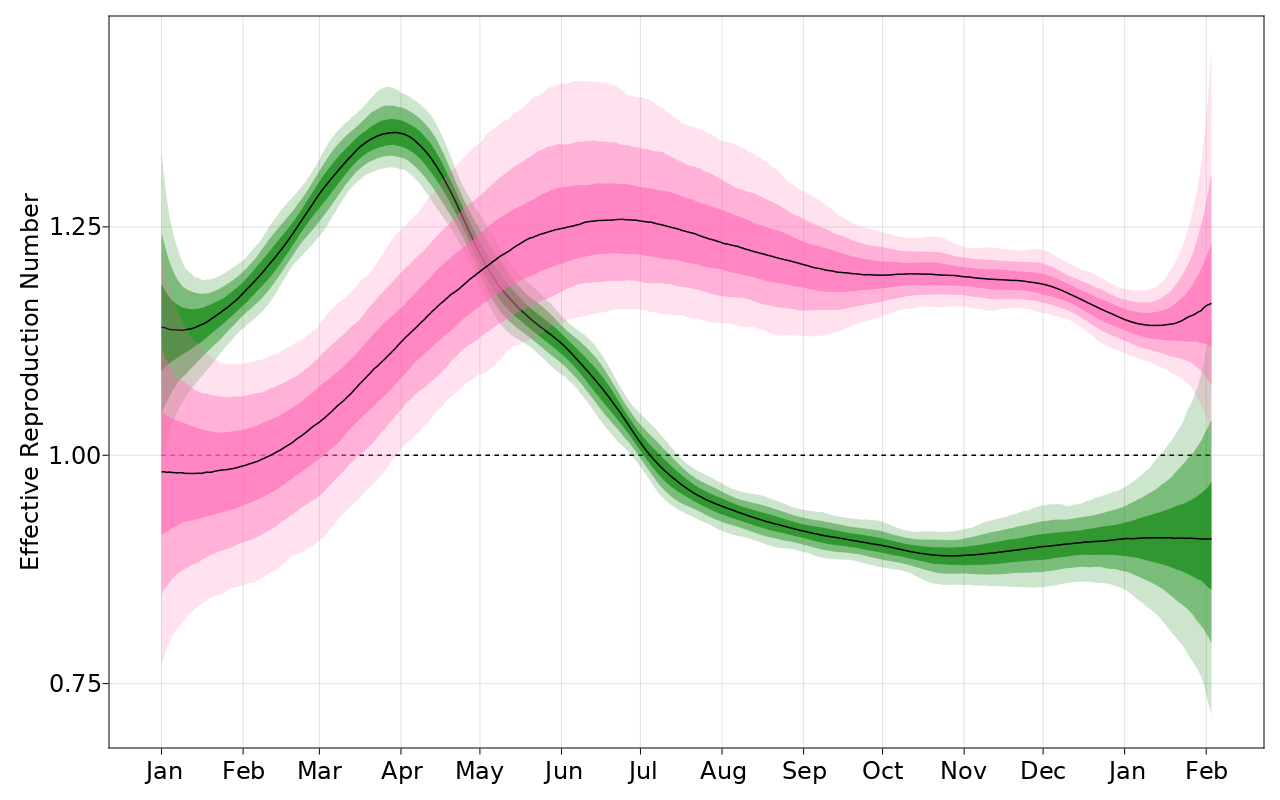

In [23]:
plot_R("synthetic", syn_dict)

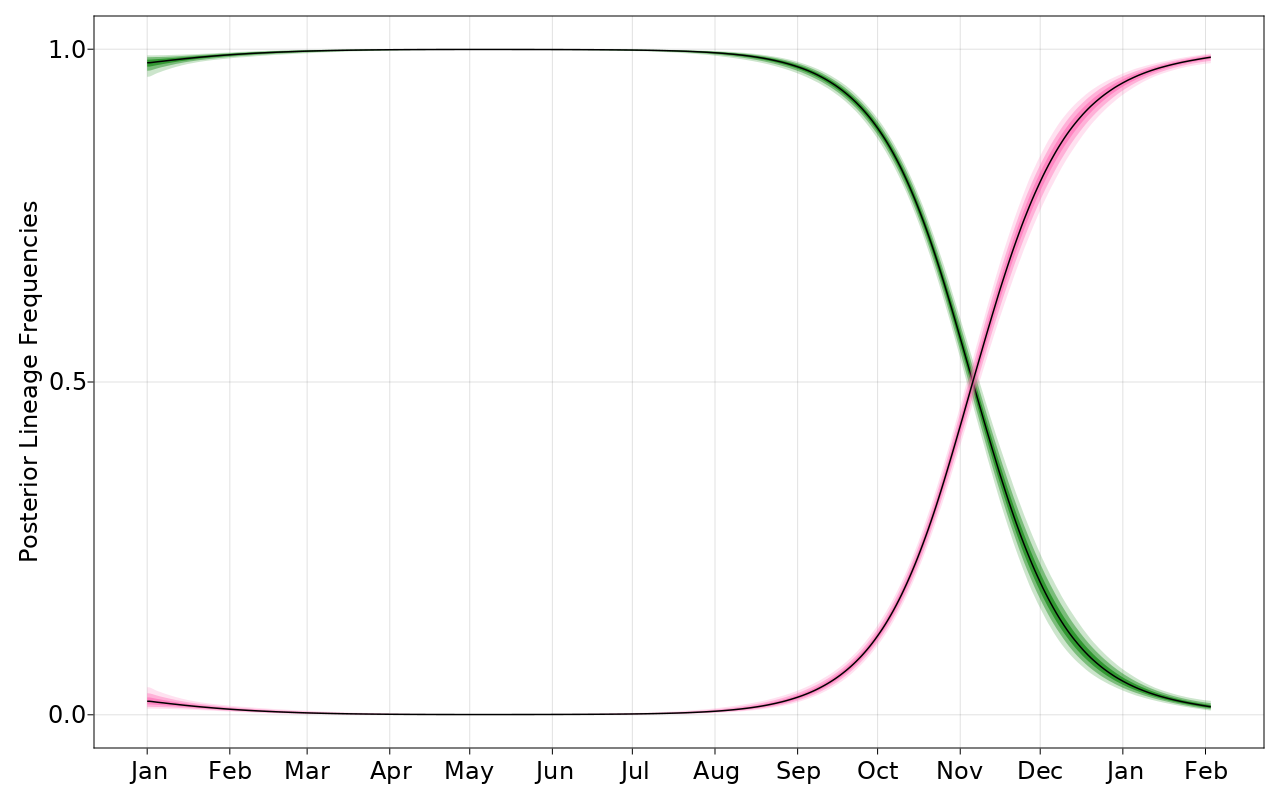

In [24]:
plot_sim_freq("synthetic", syn_dict)

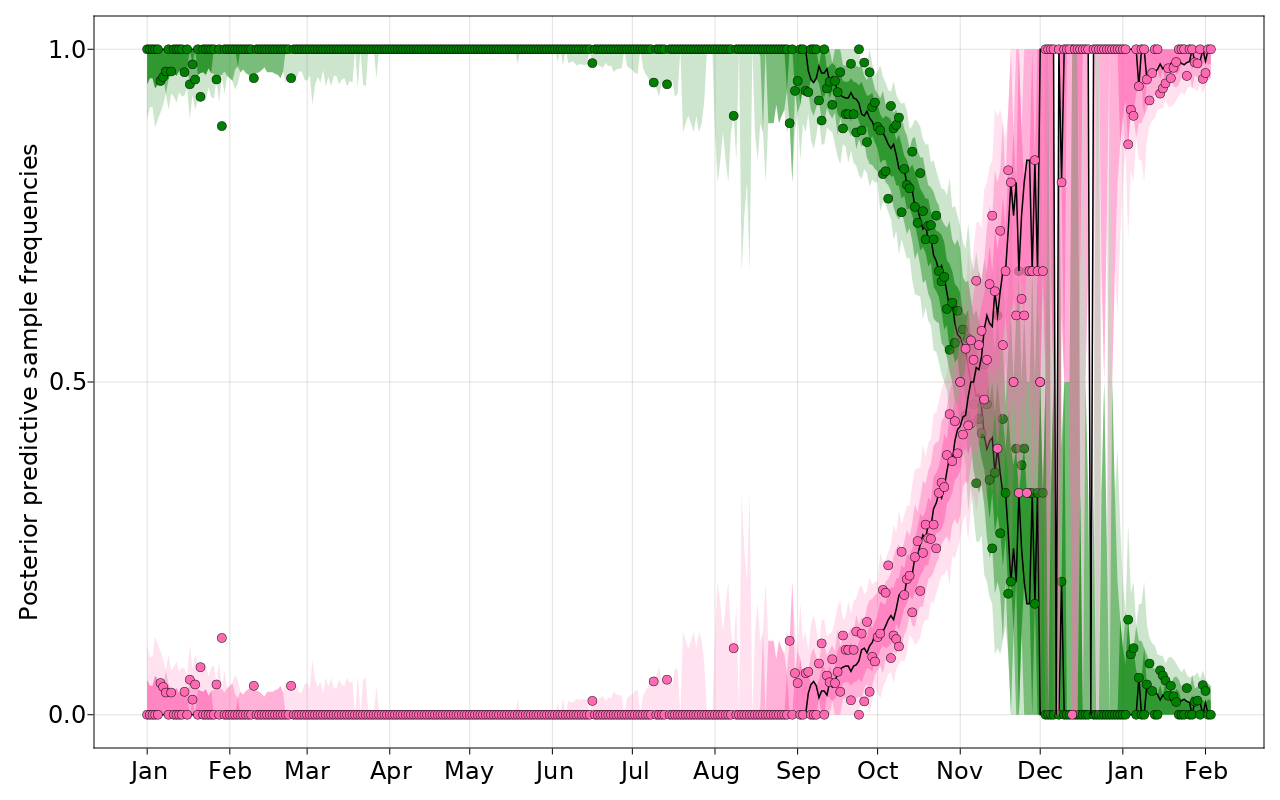

In [25]:
plot_post_pred_freq("synthetic", syn_dict)

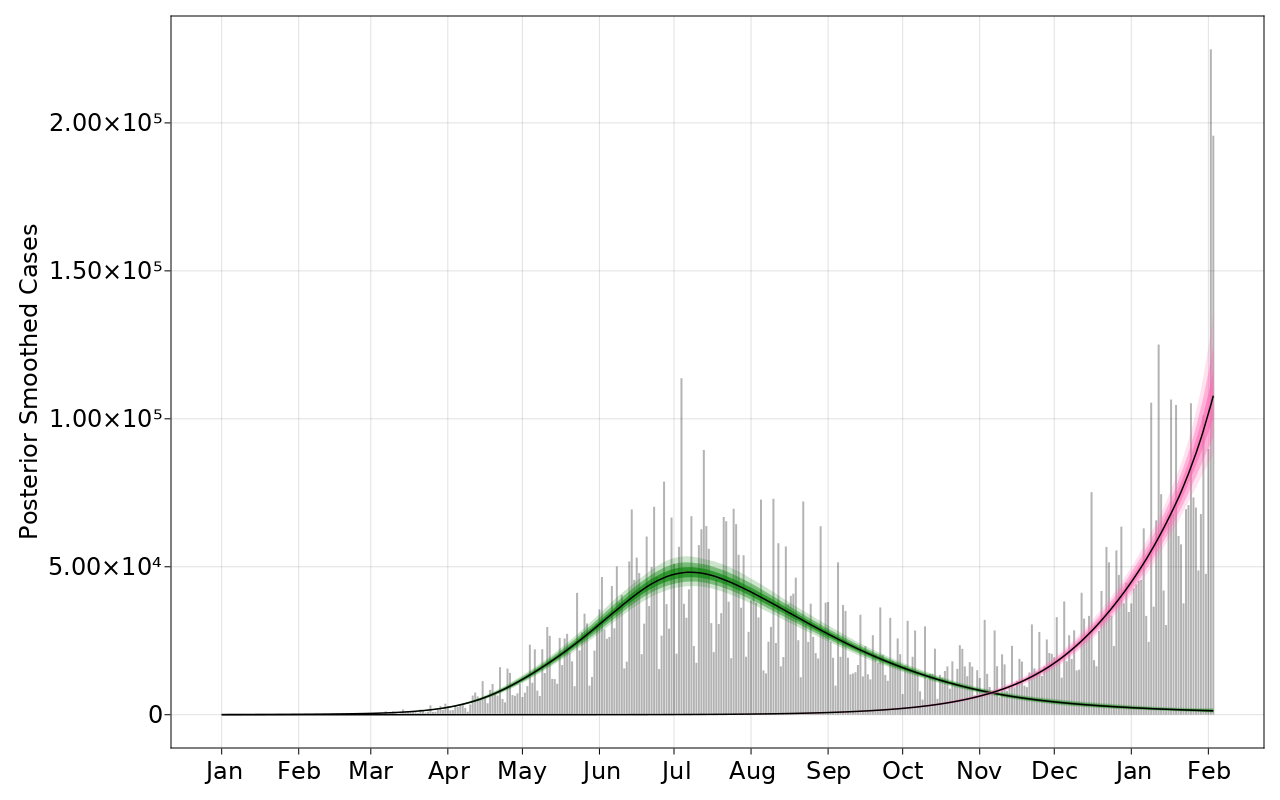

In [26]:
plot_lineage_I_prev("synthetic", syn_dict)

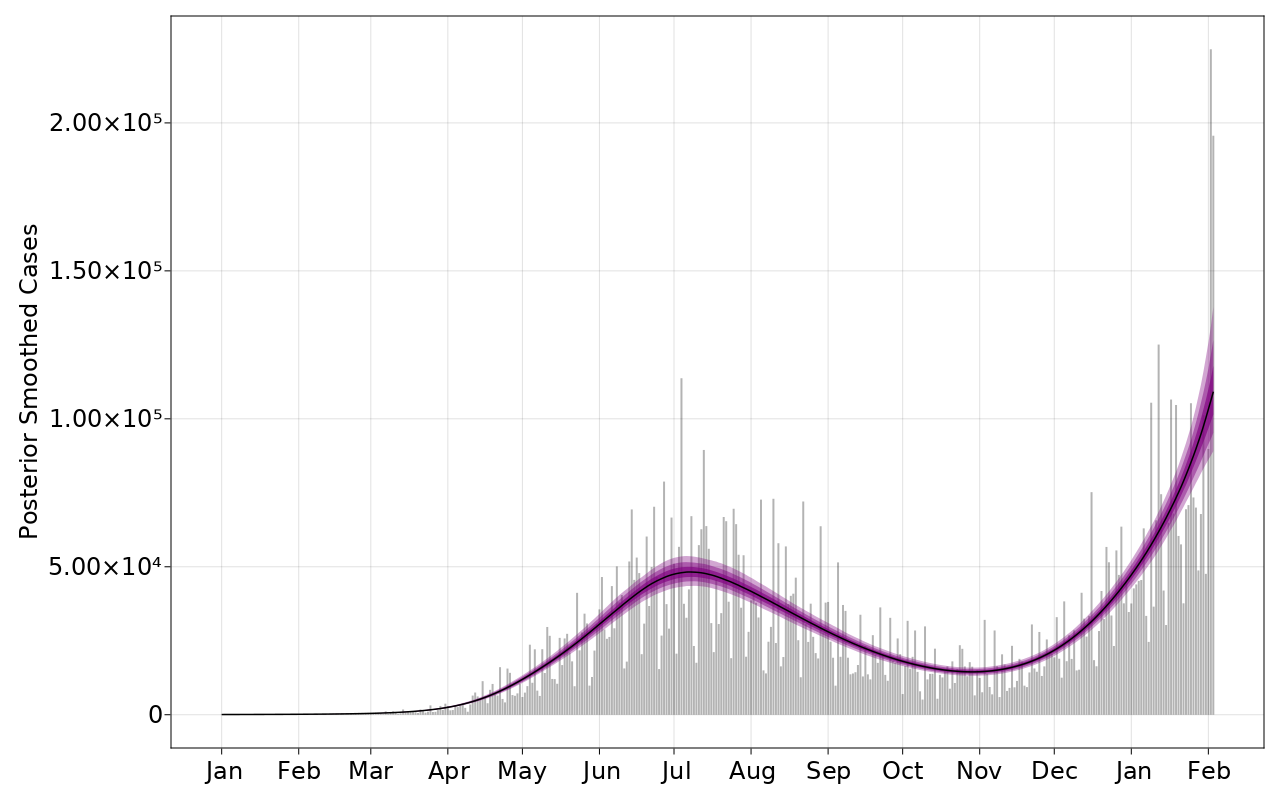

In [46]:
plot_EC_smooth("synthetic", syn_dict)

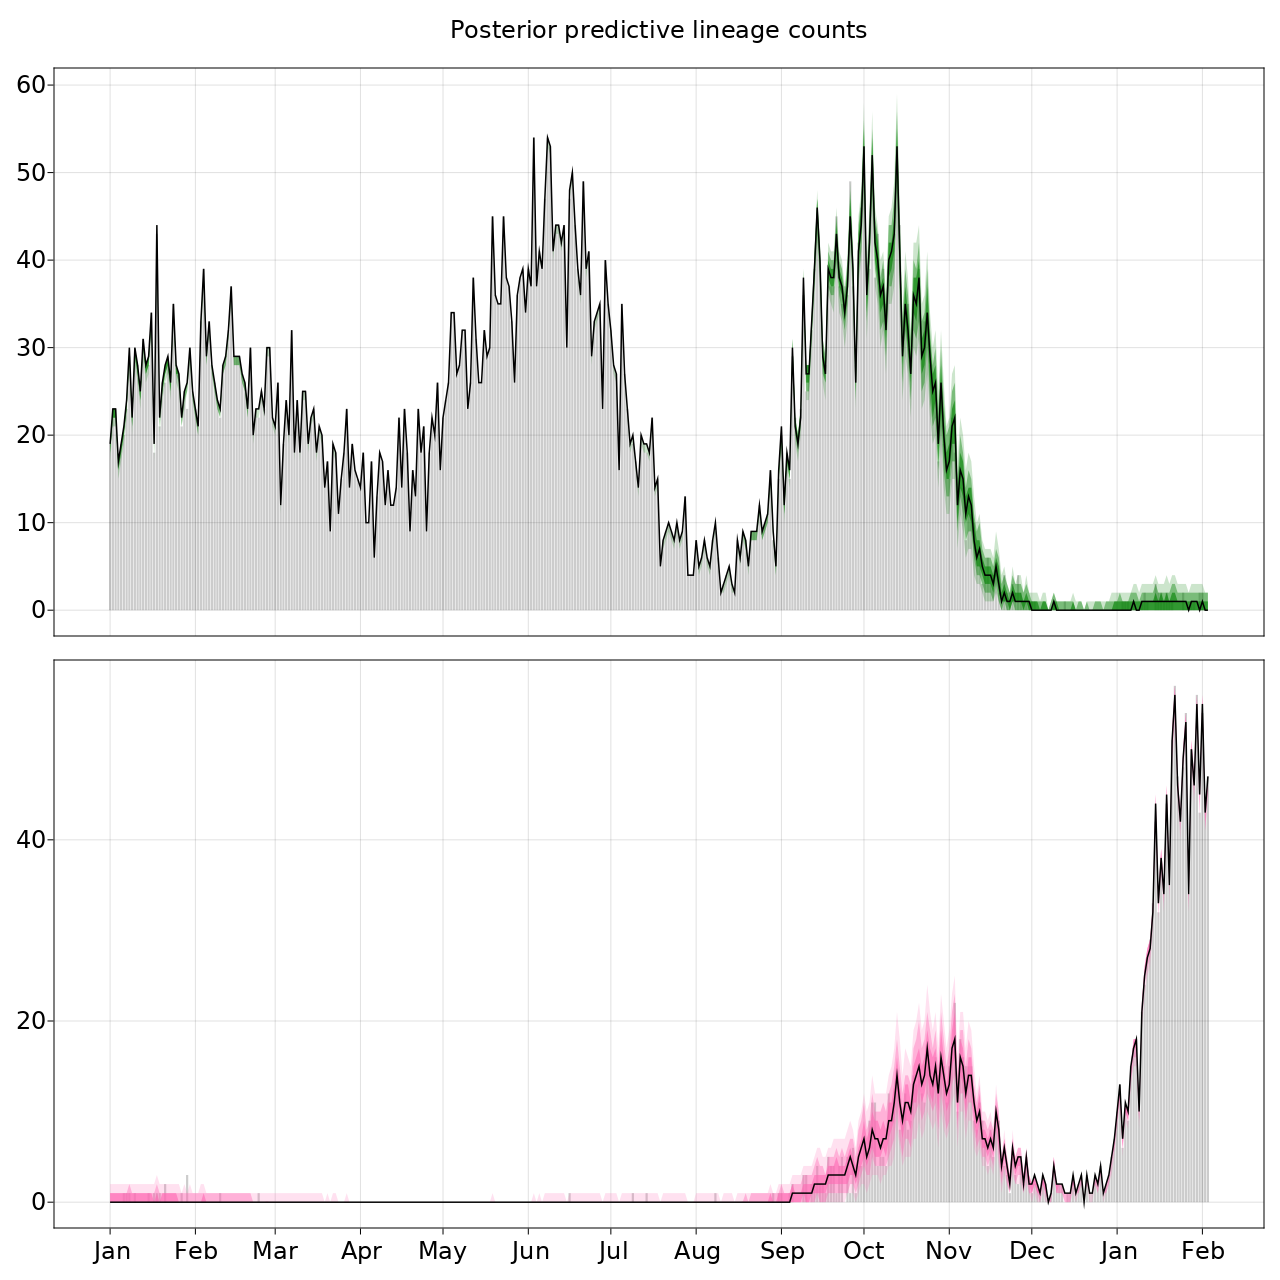

In [31]:
plot_post_pred_seq_counts("synthetic", syn_dict)

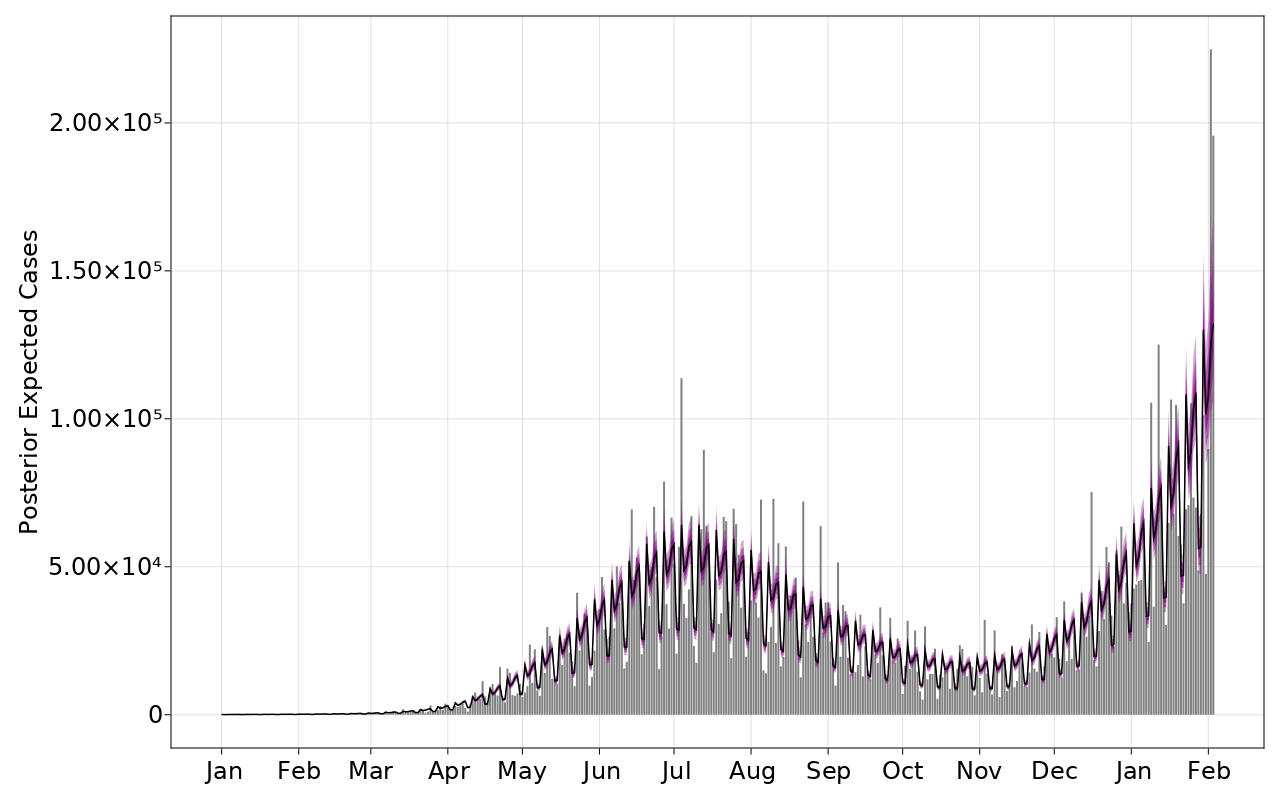

In [43]:
plot_EC("synthetic", syn_dict)